In [4]:
import numpy as np
import os, sys
from glob import glob
from tqdm import tqdm
from time import time
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        'serif'  : ['Palatino'],
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
import pandas as pd
import pickle as pkl
from hepstats.modeling import bayesian_blocks


def optimal_n_bins(y,max_bins=100):
    from scipy.stats import iqr
    n_bins = int((max(y) - min(y))/(2*iqr(y)*len(y)**(-1/3)))
    return min(n_bins,max_bins)


def bayesian_blocks_mod(y):
    if len(np.unique(y))==1:
        return None
    tol = np.std(y)/100
    blocks = bayesian_blocks(y)
    diffs = np.diff(blocks)
    mask = np.ones(len(blocks),dtype=bool)
    for i,d in enumerate(diffs):
        if d<tol:
            print(f'Deleting one bin: width = {d}')
            mask[i] = False
    return blocks[mask,...]



In [5]:
with open('traces/initial/traces_v2.0.pkl','rb') as fh:
    chain = pkl.load(fh)
    
chain.shape

(32, 16000, 4)

In [6]:
walk_indices = []
for iw,walk in enumerate(chain):
    print(f'walker {iw}')
    fail_cond = False
    for ip in [0,1,2,3]:
        print(f'    parameter {ip}')
        print(f'        mean = {np.mean(walk[:,ip].flatten()):5.5}')
        print(f'        std = {np.std(walk[:,ip].flatten()):5.5}')
        fail_cond = fail_cond or (np.std(walk[:,ip].flatten())<0.000001)
        if fail_cond:
            print('REMOVING THIS WALKER')
            break
    if fail_cond:
        continue
    else:
        walk_indices.append(iw)
chain_cleaned = np.array(chain[walk_indices,:,:])
chain_cleaned.shape

walker 0
    parameter 0
        mean = 2.3177
        std = 7.0434
    parameter 1
        mean = -5.0686
        std = 7.0114
    parameter 2
        mean = -1.8014
        std = 7.0486
    parameter 3
        mean = -3.1038
        std = 7.0432
walker 1
    parameter 0
        mean = -3.7787
        std = 7.0734
    parameter 1
        mean = 3.4579
        std = 7.0612
    parameter 2
        mean = 0.30936
        std = 7.064
    parameter 3
        mean = 1.5831
        std = 7.0513
walker 2
    parameter 0
        mean = -2.2888
        std = 7.0398
    parameter 1
        mean = 5.0643
        std = 7.0738
    parameter 2
        mean = 1.8796
        std = 7.0396
    parameter 3
        mean = 3.1229
        std = 7.0221
walker 3
    parameter 0
        mean = 5.3443
        std = 7.155
    parameter 1
        mean = -1.8874
        std = 7.0608
    parameter 2
        mean = 1.2716
        std = 7.1407
    parameter 3
        mean = -0.024908
        std = 7.1581
walker 4
   

(28, 16000, 4)

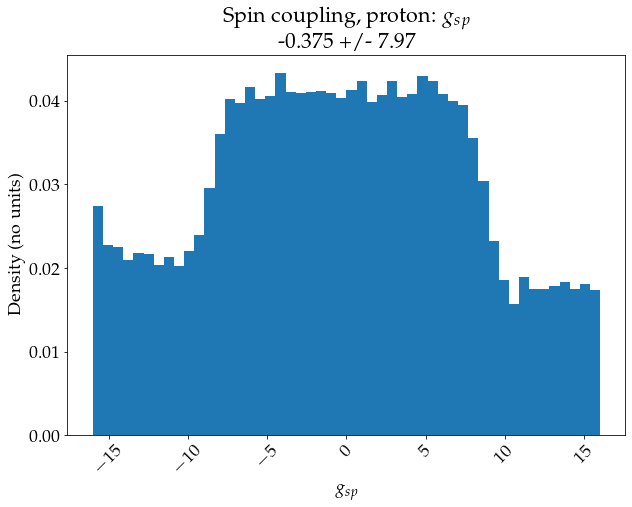

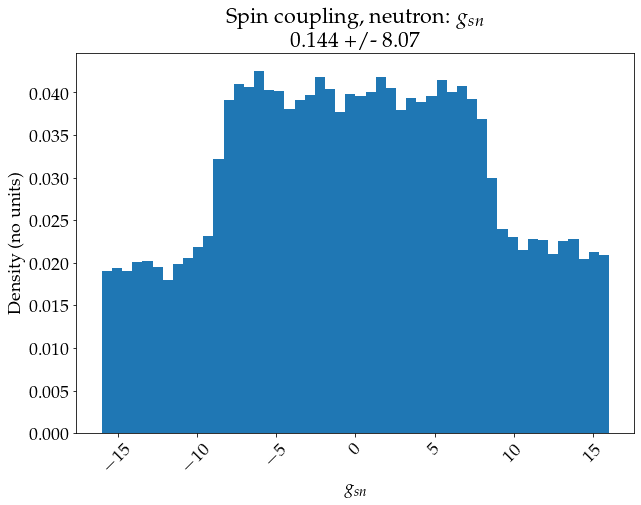

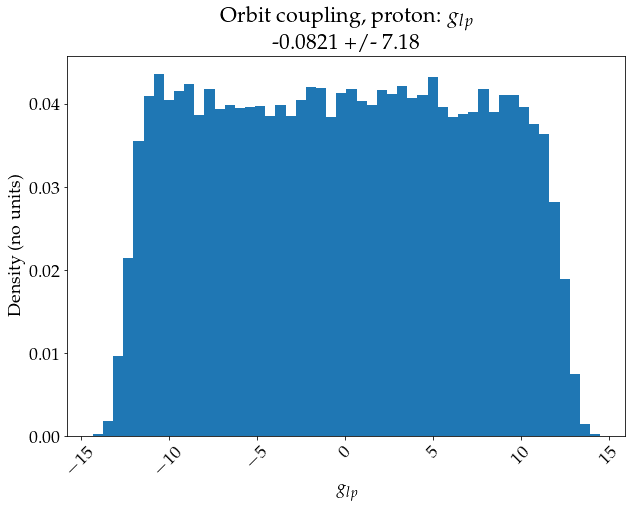

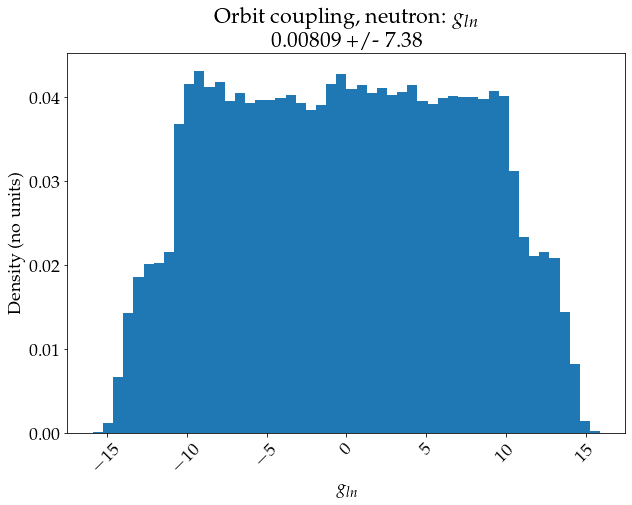

In [7]:
warmup = 400

g_sp_trace = chain_cleaned[:,warmup:,0].flatten()
g_sn_trace = chain_cleaned[:,warmup:,1].flatten()
g_lp_trace = chain_cleaned[:,warmup:,2].flatten()
g_ln_trace = chain_cleaned[:,warmup:,3].flatten()

def make_hist(data,title_string,label):
    y = data.flatten()
    n_bins = 50
    plt.figure(figsize=(10,7))
    plt.hist(y,bins=n_bins,density=True)
    y_mean = np.mean(y)
    y_std = np.std(y)
    plt.title(f"{title_string}\n{y_mean:5.3} +/- {y_std:5.3}")
    plt.xlabel(label)
    plt.ylabel('Density (no units)')
    plt.xticks(rotation=45)
    plt.show()

make_hist(g_sp_trace,r'Spin coupling, proton: $g_{sp}$',r'$g_{sp}$')
make_hist(g_sn_trace,r'Spin coupling, neutron: $g_{sn}$',r'$g_{sn}$')
make_hist(g_lp_trace,r'Orbit coupling, proton: $g_{lp}$',r'$g_{lp}$')
make_hist(g_ln_trace,r'Orbit coupling, neutron: $g_{ln}$',r'$g_{ln}$')



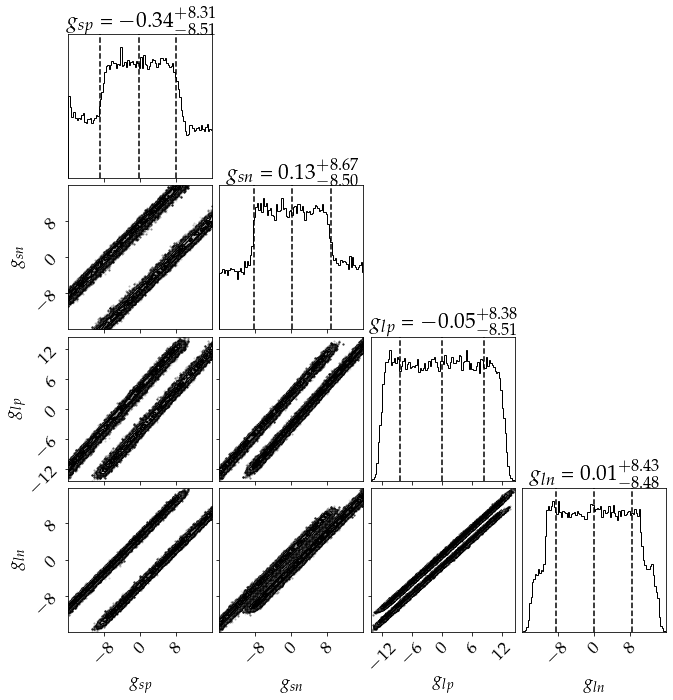

In [8]:
import corner

data = np.array([g_sp_trace.flatten(),g_sn_trace.flatten(),g_lp_trace.flatten(),g_ln_trace.flatten()]).T

# f = plt.figure(figsize=(10,10))
figure = corner.corner(data,
                       bins=100,
                       labels=[r'$g_{sp}$',r'$g_{sn}$',r'$g_{lp}$',r'$g_{ln}$'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True,
#                        title_kwargs={"fontsize": 16},
#                       fig=f,
                      )
plt.savefig('corner_plot_bad.png',dpi=300)